In [2]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Nunique #####################")
    print(dataframe.nunique())
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [4]:
# target summary with cat cols
def target_summary_with_cat(dataframe, target, categorical_col):
    summary_df = dataframe.groupby(categorical_col)[target].mean().reset_index()
    summary_df.columns = [categorical_col, "TARGET_MEAN"]
    
    print(summary_df, end="\n\n\n")
    
    # Create histogram
    plt.figure(figsize=(15, 6))
    plt.bar(summary_df[categorical_col].astype(str), summary_df["TARGET_MEAN"], color='skyblue')
    plt.xlabel(categorical_col)
    plt.ylabel(target) 
    plt.title(f"{target} mean for {categorical_col}")
    plt.xticks(rotation=45)
    plt.show()

In [6]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('submission_demand.csv')

df = pd.concat([train, test], sort=False)

In [7]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [9]:
sample_sub.head()

,id,sales
0,0,12.299886
1,1,14.303653
2,2,15.677597
3,3,14.720886
4,4,17.407804


In [10]:
df


,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


# EXPLORATORY DATA ANALYIS 

In [11]:
df["date"].min(), df["date"].max()


(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [12]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Nunique #####################
date      1916
store       10
item        50
sales      213
id       45000
dtype: int64
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################

   store  TARGET_MEAN
0      1    47.268379
1      2    67.033165
2      3    59.530602
3      4    54.902946
4      5    39.770164
5      6    39.733516
6      7    36.363735
7      8    64.142048
8      9    55.049025
9     10    58.709288




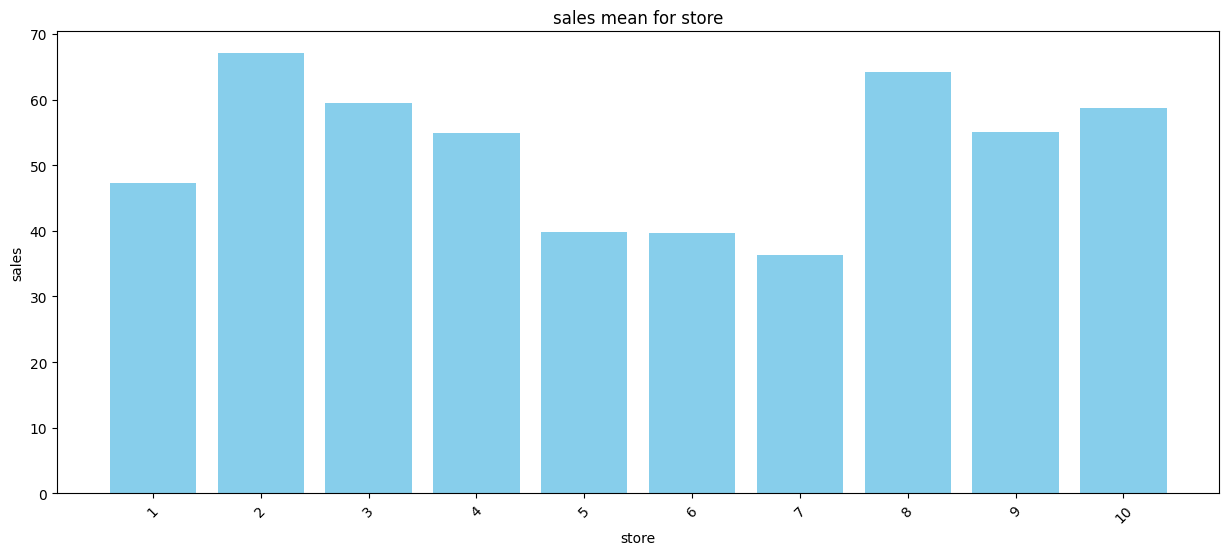

    item  TARGET_MEAN
0      1    21.981599
1      2    58.574151
2      3    36.642223
3      4    22.010241
4      5    18.358708
5      6    58.503888
6      7    58.531051
7      8    76.950055
8      9    51.389869
9     10    73.227437
10    11    69.656353
11    12    69.634940
12    13    84.316594
13    14    58.681873
14    15    88.030778
15    16    25.656079
16    17    32.994852
17    18    84.275794
18    19    40.355531
19    20    47.515936
20    21    40.317087
21    22    80.502245
22    23    29.297864
23    24    66.044633
24    25    80.686418
25    26    47.644085
26    27    22.049726
27    28    87.881325
28    29    69.618839
29    30    40.337021
30    31    58.644304
31    32    43.981763
32    33    69.560953
33    34    25.735761
34    35    65.801807
35    36    77.028916
36    37    29.258379
37    38    80.521906
38    39    43.883406
39    40    29.249398
40    41    22.002136
41    42    36.688116
42    43    51.294359
43    44    29.398193
44    45  

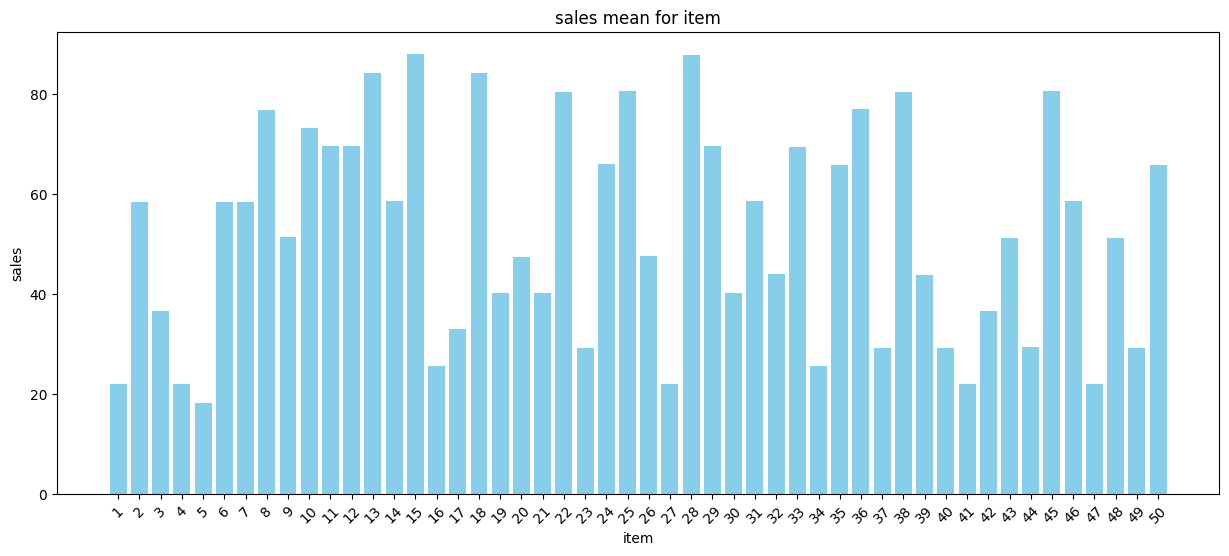

In [13]:
for col in ["store", "item"] : 
    target_summary_with_cat(df, "sales", col)

In [14]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

FEATURE EXTRACTION 

In [15]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

In [16]:
df

,date,store,item,sales,id,month,day_of_month,day_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,4,2018,1,0,0


In [17]:
df.groupby(['store' , 'item' , 'month'])['sales'].mean().head(36)

store  item  month
1      1     1        13.709677
             2        14.631206
             3        17.600000
             4        20.786667
             5        22.245161
             6        24.833333
             7        25.967742
             8        22.529032
             9        21.386667
             10       19.645161
             11       21.366667
             12       14.748387
       2     1        36.070968
             2        39.936170
             3        48.135484
             4        56.020000
             5        60.916129
             6        63.973333
             7        67.780645
             8        60.864516
             9        54.980000
             10       51.690323
             11       56.353333
             12       40.477419
       3     1        22.600000
             2        24.886525
             3        29.716129
             4        34.693333
             5        39.232258
             6        39.813333
             7       

Random Noise


In [18]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# genarates random noise in the program 
# scale is the 1.6 is the std deviation of normal distribution 
# size = (len(dataframe))  specifies the output array which is 1D with eqaul lenght to the number of rows 

In [19]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

LAG/SHIFTED FEATURES 

In [20]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])



In [21]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [365, 546])



In [22]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

In [23]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

In [24]:
df['sales'] = np.log1p(df["sales"].values) # converting to log(1+'sales')to increase the sales 

customize cost function


In [25]:
def smape(preds, target):
    n = len(preds)  # shows the number of predictions 
    masked_arr = ~((preds == 0) & (target == 0))
    # igonore cases where both pred and targtes gets 0
    preds, target = preds[masked_arr], target[masked_arr]  # remove such type of cases 
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target) # compute sum of absolute values 
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


In [26]:
# time-based  validation sets 

test.date.max(), test.date.min()


(Timestamp('2018-03-31 00:00:00'), Timestamp('2018-01-01 00:00:00'))

In [27]:
# Train set: Data up to the beginning of 2017 (end of 2016).
train = df.loc[(df["date"] < "2017-01-01"), :]

# Validation set: The first 3 months of 2017.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# Selecting features and target variables
cols = [col for col in train.columns if col not in ['date', 'id', 'sales', 'year']]

Y_train = train['sales']  # Target variable for the training set
X_train = train[cols]     # Feature variables for the training set

Y_val = val['sales']      # Target variable for the validation set
X_val = val[cols]         # Feature variables for the validation set

# Display the shapes of the target and feature variables for both training and validation sets
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 141), (45000,), (45000, 141))

TIME SERIES MODEL FOR LIGHTGBM 

In [28]:
# LightGBM parameters
lgb_params = {'num_leaves': 10, 
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)


In [29]:
# Train a model 

In [30]:
# Train the model
model = lgb.train(
    lgb_params, 
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    callbacks=[lgb.early_stopping(lgb_params['early_stopping_rounds'])]
)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.0291767	valid_1's l2: 0.0313817


In [31]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.83858172111323

In [32]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
       print(feat_imp.head(num))
    return feat_imp 



                        feature  split       gain
16          sales_roll_mean_546    938  58.364644
12                sales_lag_364   1269  12.814833
15          sales_roll_mean_365    650   8.576474
59   sales_ewm_alpha_05_lag_365    403   4.566302
1                   day_of_year    956   3.025244
..                          ...    ...        ...
77                       item_6      0   0.000000
110                     item_39      0   0.000000
73                       item_2      0   0.000000
114                     item_43      0   0.000000
70                      store_9      0   0.000000

[141 rows x 3 columns]


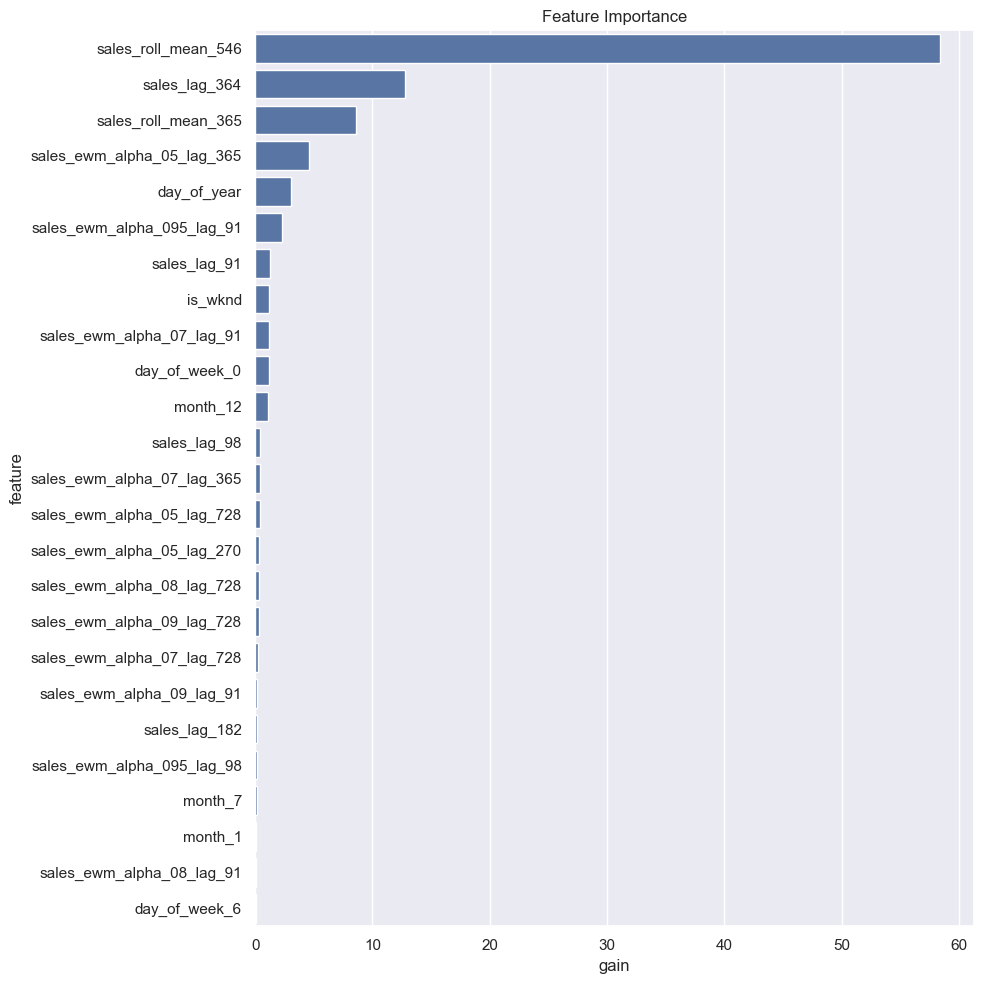

                        feature  split       gain
16          sales_roll_mean_546    938  58.364644
12                sales_lag_364   1269  12.814833
15          sales_roll_mean_365    650   8.576474
59   sales_ewm_alpha_05_lag_365    403   4.566302
1                   day_of_year    956   3.025244
..                          ...    ...        ...
77                       item_6      0   0.000000
110                     item_39      0   0.000000
73                       item_2      0   0.000000
114                     item_43      0   0.000000
70                      store_9      0   0.000000

[141 rows x 3 columns]


111

In [33]:
# Plot the top 200 feature importances and display the top 30 features
plot_lgb_importances(model, num=200)
plot_lgb_importances(model, num=30, plot=True)

# Get the feature importances
feat_imp = plot_lgb_importances(model, num=200)

# Identify features with zero importance
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

# Filter out features with zero importance
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

In [34]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}



In [35]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)